### Project: Variance Reduction in American option
### Author: Wenkang Kong, Jiankun Ni, Zhenhai Lve, Tian Wang, Kangyi Xu, Zhengyin Chen
### Date: 2023 Fall
### Class: MF703 Programming for Mathematical Finance


In [1]:
import numpy as np
import pandas as pd
import copy
import scipy
from scipy.special import comb
from scipy.stats import norm, truncnorm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

Option information American calls on SPY:

Time: 19 OCT 2023

SPY: 426.43

strike: 415

price: 17.44

sigma: 0.214 (use VIX index as imp vol)  x
        0.175214018664983 (IVM)

risk free rate: 0.0558 (US 1 month treasury rate)

Reference:

1.https://finance.yahoo.com/quote/%5EVIX/?guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAJPlEYAoao_dXiHKgmPorAYL9QxvZA5azOYgrHYUVnCjyeTiCBUW0Bp2kFtuaIREXC_vGzMVJM0dDTRGNCRXlKnYJmCv6aKfwY54iNtKmncoALxmE9bnfu_Kic8wT1dQwyEjNxQEI3eYubyRo6zG1LlgUCKevn8doEuGPk9Z4Xs3

2.https://ycharts.com/indicators/1_month_treasury_rate#:~:text=Basic%20Info,day%20and%204.12%25%20last%20year

In [26]:
class normal_ao_pricing:
    """
    This class is meant for using normal ways to calculate the option price for American Options.
    There are mainly two parts： The first is to use GBM for path simulation, 
    the second is to use LSMC method to gain estimated option price given the simulation path.
    Numbers of simulations will finally approximate the actual stock price

    """
    def __init__(self, S0, strike, rf, sigma, T, npath, opt_type, mkt_quote):
        """
        S0 denotes the current stock price.
        
        strike denotes the strike price.
        
        rf denotes the risk free rate(we use US 1 month treasury rate as
        reference since the option's maturity is not long in most cases).
        
        sigma denotes standard deviation, we use VIX index as imp volatility instead.
        
        T denotes the maturity besides the initial day.
        
        npath denotes the number of simulation paths we want to create.
        
        opt_type denotes the option type, there are only two types: call and put.
        
        paths stores the simulated paths that will be generated. It is a pd.DataFrame() type.
    
        """
        self.S0 = S0
        self.rf_daily =rf/365
        self.strike = strike
        self.sigma_daily = sigma/365**0.5
        self.T = T
        self.npath = npath
        self.opt_type = opt_type
        self.paths = pd.DataFrame(np.zeros(self.npath)+self.S0)
        self.mkt_quote = mkt_quote
        
        self.normal_paths = pd.DataFrame()
        self.normal_total_std = []
        self.normal_pricing_mean = []
        
        self.curr_total_std = []
        self.curr_pricing_mean = []
        
    def paths_simulation(self):
        """
        This function simulate paths in normal ways and store the data in self.paths.
        
        """
        self.paths = pd.DataFrame(np.zeros(self.npath)+self.S0)
        
        for i in range(self.T):
            curr_day = self.paths.iloc[:,i]
            nxt_day = curr_day * np.exp(self.rf_daily-self.sigma_daily**2/2+self.sigma_daily * np.random.normal(size=self.npath))
            self.paths = pd.concat([self.paths,nxt_day], axis=1)
            
        self.paths.columns = list(range(self.T+1))
        
        
    def path_antithetic_variable(self):
        """
        This function simulate paths using antithetic variables and store the data in self.paths.
        
        """
        
        self.paths = pd.DataFrame(np.zeros(self.npath)+self.S0)
        
        for i in range(self.T):
            curr_day = self.paths.iloc[:,i]
            rand_wk = np.random.normal(size=int(self.npath/2))
            rand_wk = np.concatenate((rand_wk,-rand_wk))
            nxt_day = curr_day * np.exp(self.rf_daily-self.sigma_daily**2/2+self.sigma_daily * rand_wk)
            self.paths = pd.concat([self.paths,nxt_day], axis=1)
            
        self.paths.columns = list(range(self.T+1))
            
            
    def path_simulation_importance_sampling(self, n_times=1000):
        """
        This function simulate paths by importance sampling and store the data in self.paths.
        
        n_times denotes the time we tried to get the minimun u.
        
        """
        self.paths = pd.DataFrame(np.zeros(self.npath)+self.S0)
        
        p = scipy.stats.norm(self.rf_daily - self.sigma_daily**2 /2,self.sigma_daily)
        q = lambda mu: scipy.stats.norm(mu, self.sigma_daily)
        z_T = lambda x, mu, sig: mu + sig*x
        
        if self.opt_type == "call":
            f_0 = lambda z: np.exp(-self.rf_daily*self.T)*np.maximum(0, self.S0*np.exp(z)-self.strike)
        elif self.opt_type == "put":
            f_0 = lambda z: np.exp(-self.rf_daily*self.T)*np.maximum(0, self.strike-self.S0*np.exp(z))
        
        def arg_min(x):
            x_T = np.random.normal(0, 1, n_times)
            z = z_T(x_T,self.rf_daily - self.sigma_daily**2 /2,self.sigma_daily)
            return np.mean( f_0(z)**2 * p.pdf(z)/q(x).pdf(z))

        mu_star = scipy.optimize.fmin(lambda x: arg_min(x), (np.log(self.strike/self.S0)-0.5*self.sigma_daily**2), disp=True)
        
        
        for i in range(self.T):
            curr_day = self.paths.iloc[:,i]
            nxt_day = curr_day * np.exp(mu_star/self.T+self.sigma_daily * np.random.normal(size=self.npath))
            self.paths = pd.concat([self.paths,nxt_day], axis=1)
            
        self.paths.columns = list(range(self.T+1))
        
        
    def polynomial_power(self, n, data):
        """
        Polynomial power function used by LSRegression to estimate the conditional discounted payoff.
        """
        result = data
        if n == 1:
            return result.values.reshape(-1, 1)
        for i in range(2,n+1):
            result = pd.concat([result,data**i], axis = 1)
        return result
        
        
    def pricing(self):
        """
        This function is the pricing method for American call/put options. Given the self.paths, we determine the
        best strategy for simulation path in order for option pricing and return the average option price.
        
        The pricing method is fixed regardless of how we simulate and generate the paths.
        
        """
        
        # Preparations for calculating.
        # Create 'payoff_at_maturity', 'option value at maturity' and 'Executed date' columns on self.paths
        
        if self.opt_type == "put":
            self.paths['payoff_at_maturity'] = self.strike - self.paths[self.T]
        elif self.opt_type == "call":
            self.paths['payoff_at_maturity'] = self.paths[self.T] - self.strike
        else:
            raise ValueError("Option type must be call or put.")
        
        self.paths['payoff_at_maturity'] = self.paths['payoff_at_maturity'].apply(lambda x: max(x,0))
        self.paths['option value at maturity'] = self.paths['payoff_at_maturity']
        self.paths['Executed date'] = self.T
        
        
        # Using LSMC mothed for pricing.
        LR = LinearRegression()
        
        # We start from the penultimate column of simulated path, end from
        # the first column of simulated path(). For every day we run through, we do 
        # LR with next day and calculate the expected payoff of next day. By comparing
        # today's payoff and next day's payoff, we decide whether exercise the option or not.
        for i in range(self.paths.shape[1]-5, -1, -1):
            day_i = self.paths[[i, 'option value at maturity']]
            
            if self.opt_type == "put":
                day_i = day_i[day_i[i] < self.strike]
            else:
                day_i = day_i[day_i[i] > self.strike]
            
            if day_i.shape[0] == 0:
                continue
                
            x = self.polynomial_power(3, day_i[i])
            y = day_i['option value at maturity']
            
            LR.fit(x, y)
            
            day_i['expected continuation value'] = LR.predict(x)
            
            if self.opt_type == "put":
                day_i['execution value'] = day_i[i].apply(lambda a: max(0,self.strike-a))

            else:
                day_i['execution value'] = day_i[i].apply(lambda a: max(0,a-self.strike))
                
            day_i['if execute'] = day_i['execution value'] > day_i['expected continuation value']
            
            def update_fv(row):
                if row['if execute']:
                    return row['execution value'] * (1+self.rf_daily)**(self.T-i)
                else:
                    return row['option value at maturity']
                
            day_i['updated option value at maturity'] = day_i.apply(update_fv, axis = 1)
                
            self.paths.loc[day_i.index,'option value at maturity'] = day_i['updated option value at maturity']
            self.paths.loc[day_i[day_i['if execute']==True].index,'executed on'] = i
        
        return (self.paths['option value at maturity'].mean() * (1+self.rf_daily)**(-self.T))
    
    
    def simulation_stratified(self, k=10, simu_type=0):
        """
        This function returns the pricing of the option price which realizes the variance reduction. 
        There is chance that the function will return nan because each inverval should have at least 
        2 simulation paths so that self.pricing can be operated.

        This function divides the simulation paths into k intervals by terminal value of the path. 
        For each interval, calculate the simu_type pricing of each path and get the average of pricing.
        Finally, add the weighted pricing (by pdf) to get the final pricing of the option.

        k : the number of intervals we want to divide.
        sumu_type: The path simulation type. If simu_type == 0, it uses normal pricing method.
                                             If simu_type == 1, it uses antithetic variable method.
                                             If simu_type == 2, it uses importance sampling method.

        """
        # simulate paths

        if simu_type == 0:
            self.paths_simulation()
        elif simu_type == 1:
            self.path_antithetic_variable()
        elif simu_type == 2:
            self.path_simulation_importance_sampling()
        else:
            raise ValueError("simu_type must be 0, 1 or 2.")



        start = min(self.paths.iloc[:, -1])
        end = max(self.paths.iloc[:, -1])
        points = np.linspace(start, end, k + 1)

        total_option_price = 0
        for i in range(len(points)-1):
            left, right = points[i], points[i+1]
            df = self.paths[(self.paths.iloc[:, -1] > left) & (self.paths.iloc[:, -1] <= right)]

            save = self.paths
            self.paths = df

            pricee = self.pricing() 

            self.paths = save
            total_option_price += pricee * len(df)/len(self.paths)

        return total_option_price               
            

    
    def cal_mean_std(self, simu_type=0, start=410, end=440, times=10):
        """
        In this function we want to calculate the mean and std of our pricing using the normal method if 
        it is not stored in self.normal_pricing_mean and self.normal_total_std.
        Then we will calculate the calculate the mean and std of our pricing with our targeted method according 
        to the simu_type.
        Finally we will visualize the output.
        
        simu_type: if simu_type == 0: it means we only need to calculate the original method.
                    if simu_type == 1: we need to consider the antithetic variable method.
                    if simu_type == 2: we need to consider the importance sampling path.
        
        
/        start & end: The begin and end of the strike boundary we select.
        
        times: The time we want to simulate to calculate the std and mean.

        
        """
        
        if not self.normal_total_std:
            self.normal_total_std = []
            self.normal_pricing_mean = []

            strikes = np.arange(start, end+1)
            for i in tqdm(strikes):
                temp = []
                for j in range(times):
                    self.paths_simulation()
                    price = self.pricing()
                    temp.append(price)

                self.normal_total_std.append(np.std(temp))
                self.normal_pricing_mean.append(np.mean(temp))
            
        if simu_type == 0:
        
            plt.plot(strikes, self.normal_total_std)
            plt.xlabel('strikes')
            plt.ylabel('std')
            if self.opt_type == "call":
                plt.title('Standard deviation v.s. Strikes in call option')
            else:
                plt.title('Standard deviation v.s. Strikes in put option')
            plt.show()
            
        else:
            self.curr_total_std = []
            self.curr_pricing_mean = []
            
            strikes = np.arange(start, end+1)
            for i in tqdm(strikes):
                temp = []
                for j in range(times):
                    if simu_type == 1:
                        self.path_antithetic_variable()
                    elif simu_type == 2:
                        self.path_simulation_stratified()
                    elif simu_type == 3:
                        self.path_simulation_importance_sampling()
                    else:
                        raise ValueError("simu_type can only be 0, 1, 2 or 3")
                    price = self.pricing()
                    temp.append(price)        
                
                self.curr_total_std.append(np.std(temp))
                self.curr_pricing_mean.append(np.mean(temp))
            
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

            ax1.plot(strikes, self.normal_total_std)
            ax1.set_title('Standard method')
            ax1.set_xlabel('strikes')
            ax1.set_ylabel('std')

            ax2.plot(strikes, self.curr_total_std )
            if simu_type == 1:
                ax2.set_title('Antithetic Variable')
            elif simu_type == 2:
                ax2.set_title('Importance Sampling')
            ax2.set_xlabel('strikes') 
            ax2.set_ylabel('std')

            if self.opt_type == "call":
                fig.suptitle('Standard deviation v.s. Strikes in call option')
            else:
                fig.suptitle('Standard deviation v.s. Strikes in put option')


            plt.show()


    
    def drawing_path_with_strike(self,simu_type = 3):
        self.paths_simulation()
        self.normal_paths = self.paths
        self.path_simulation_importance_sampling()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        ax1.plot(self.normal_paths.iloc[:, self.normal_paths.columns[0]:self.normal_paths.columns[-5]].T)
        ax1.plot([self.normal_paths.columns[0], self.normal_paths.columns[-5]], [self.strike, self.strike], 'k--', linewidth=3)
        ax1.set_title('Standard Method')
        ax1.set_xlabel('Time') 
        ax1.set_ylabel('Value')
        
        ax2.plot(self.paths.iloc[:, self.paths.columns[0]:self.paths.columns[-5]].T)
        ax2.plot([self.paths.columns[0], self.paths.columns[-5]], [self.strike, self.strike], 'k--', linewidth=3)
        ax2.set_title('Importance Sampling')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Value')
        
        if self.opt_type == "call":
            fig.suptitle('Paths simulation in call option')
        else:
            fig.suptitle('Paths simulation in put option')

        plt.show()
        
        
    def draw_final_price_pdf(self, simu_type = 1):
        self.paths_simulation()
        self.normal_paths = self.paths
        if simu_type == 1:
            self.path_antithetic_variable()
        elif simu_type == 2:
            self.path_simulation_importance_sampling()
        else:
            raise ValueError("simu_type can only be 0, 1, 2 or 3")
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        sns.kdeplot(self.normal_paths.iloc[:,self.normal_paths.columns[-5]],ax=ax1, fill=True)
        ax1.set_title('Standard Method')
        ax1.set_xlabel('Time') 
        ax1.set_ylabel('Value') 
        
        sns.kdeplot(self.paths.iloc[:,self.paths.columns[-5]],ax=ax2, fill=True)
        if simu_type == 1:
            ax2.set_title('Antithetic Variable')
        elif simu_type == 2:
            ax2.set_title('Stratified Sampling')
        elif simu_type == 3:
            ax2.set_title('Importance Sampling')
        ax2.set_xlabel('Time') 
        ax2.set_ylabel('Value')
        
        if self.opt_type == "call":
            fig.suptitle('PDF of final simulation values in call option')
        else:
            fig.suptitle('PDF of final simulation values  in put option')
            
        plt.show()
        
    
    def comparison_visual(self, simu_type = 1, times = 100):
        # x1 stores pricing without refinement,
        # x2 stores pricing with refinement.
        x1 = []
        x2 = []
        for i in tqdm(range(times)):
            self.paths_simulation()
            x1.append(self.pricing())
            
            if simu_type == 1:
                self.path_antithetic_variable()
            elif simu_type == 2:
                self.path_simulation_importance_sampling()
            else:
                raise ValueError("simu_type can only be 0, 1, 2 or 3")
            x2.append(self.pricing())
        
        sns.kdeplot(x1,fill=True, color="b")
        sns.kdeplot(x2,fill=True, color="r")
        plt.legend(["w/o Improve","Improve","market queto"])
        plt.axvline(x=np.mean(x1), linestyle=":", color="b")
        plt.axvline(x=np.mean(x2), linestyle=":", color="r")
        
        if self.opt_type == "call":
            plt.axvline(x=self.mkt_quote, linestyle="-", color="black")
            plt.annotate("market", xy=(self.mkt_quote, 0.5), xytext=((int(self.mkt_quote)), 0.5), arrowprops=dict(arrowstyle="->"))
            if simu_type == 1:
                plt.title('American Call on SPY using Antithetic Variable method, K={}'.format(self.strike))
            elif simu_type == 2:
                plt.title('American Call on SPY using Importance Sampling method, K={}'.format(self.strike))

            plt.xlabel("call price")
        else:
            plt.axvline(x=self.mkt_quote, linestyle="-", color="black")
            plt.annotate("market", xy=(self.mkt_quote, 0.5), xytext=((int(self.mkt_quote)), 0.5), arrowprops=dict(arrowstyle="->"))
            
            if simu_type == 1:
                plt.title('American Put on SPY using Antithetic Variable method, K={}'.format(self.strike))
            elif simu_type == 2:
                plt.title('American Put on SPY using Importance Sampling method, K={}'.format(self.strike))
            
            plt.xlabel("put price")
        
        plt.show()
            
            
        
    
        
        

In [19]:
answer = []
for i in range(30):
    aop = normal_ao_pricing(426.43, 438, 0.0558, 0.1515, 29, 1000, "call")
    aop.paths_simulation()
    price = aop.pricing()
    answer.append(price)
answer = np.array(answer)
np.nanmean(answer)

3.580637775130282

In [21]:
aop = normal_ao_pricing(426.43, 438, 0.0558, 0.1515, 29, 1000, "call")
answer = []
while(len(answer) != 20):
    # I think the maximum of k is 30
    price = aop.simulation_stratified(25)
    if price:
        answer.append(price)
answer = np.array(answer)
np.nanmean(answer)

5.0423075592750966

100%|███████████████████████████████████████████| 31/31 [01:10<00:00,  2.29s/it]


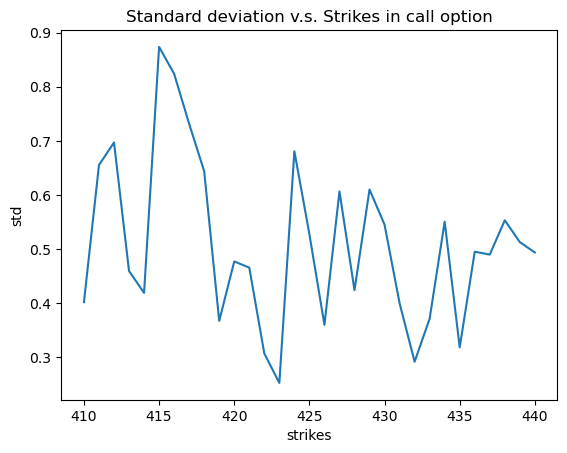

 35%|███████████████▎                           | 11/31 [02:20<04:14, 12.75s/it]


KeyboardInterrupt: 

In [5]:
aop = normal_ao_pricing(426.43, 415, 0.0558, 0.175, 29, 1000, "call")
aop.cal_mean_std()
aop.cal_mean_std(simu_type=1, times=50)
aop.cal_mean_std(simu_type=2, times=50)
aop.cal_mean_std(simu_type=3, times=50)


In [ ]:
aop = normal_ao_pricing(426.43, 415, 0.0558, 0.175, 29, 1000, "call")
aop.drawing_path_with_strike()

In [ ]:
aop = normal_ao_pricing(426.43, 415, 0.0558, 0.175, 29, 1000, "put")
aop.drawing_path_with_strike()

In [ ]:
aop = normal_ao_pricing(426.43, 415, 0.0558, 0.175, 29, 1000, "call")
aop.draw_final_price_pdf(1)
aop.draw_final_price_pdf(2)

100%|█████████████████████████████████████████| 100/100 [00:34<00:00,  2.86it/s]


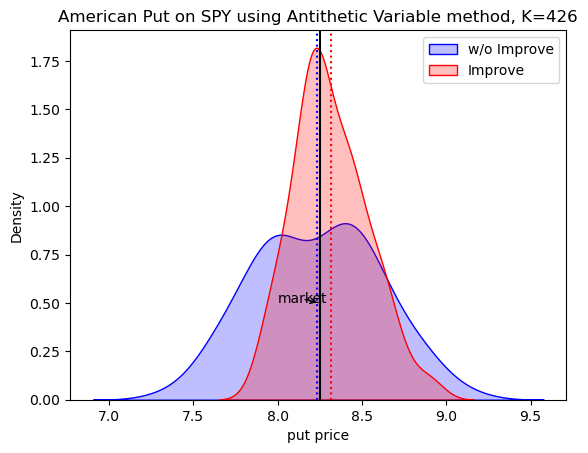

In [11]:
aop = normal_ao_pricing(426.43, 426, 0.0558, 0.1885044676, 29, 1000, "put", 8.25)
aop.comparison_visual(1, 100)

100%|█████████████████████████████████████████| 100/100 [00:38<00:00,  2.59it/s]


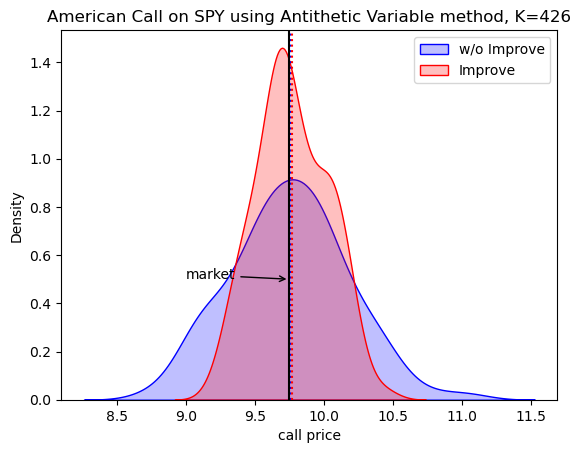

In [12]:
aop = normal_ao_pricing(426.43, 426, 0.0558, 0.175, 29, 1000, "call", 9.75)
aop.comparison_visual(1, 100)

  1%|▍                                          | 1/100 [00:00<00:28,  3.49it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 19


  2%|▊                                          | 2/100 [00:00<00:27,  3.51it/s]

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 7
         Function evaluations: 15


  3%|█▎                                         | 3/100 [00:00<00:28,  3.44it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 20


  4%|█▋                                         | 4/100 [00:01<00:27,  3.47it/s]

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 5
         Function evaluations: 13


  5%|██▏                                        | 5/100 [00:01<00:27,  3.51it/s]

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 5
         Function evaluations: 12


  6%|██▌                                        | 6/100 [00:01<00:26,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 5
         Function evaluations: 12


  7%|███                                        | 7/100 [00:01<00:26,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 5
         Function evaluations: 12


  8%|███▍                                       | 8/100 [00:02<00:26,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 7
         Function evaluations: 17


  9%|███▊                                       | 9/100 [00:02<00:25,  3.55it/s]

Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 6
         Function evaluations: 15


 10%|████▏                                     | 10/100 [00:02<00:25,  3.55it/s]

Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 5
         Function evaluations: 13


 11%|████▌                                     | 11/100 [00:03<00:25,  3.55it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 13


 12%|█████                                     | 12/100 [00:03<00:24,  3.56it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 14


 13%|█████▍                                    | 13/100 [00:03<00:24,  3.58it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 13


 14%|█████▉                                    | 14/100 [00:03<00:24,  3.56it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 18


 15%|██████▎                                   | 15/100 [00:04<00:24,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 5
         Function evaluations: 13


 16%|██████▋                                   | 16/100 [00:04<00:23,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 13


 17%|███████▏                                  | 17/100 [00:04<00:23,  3.52it/s]

Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 6
         Function evaluations: 13


 18%|███████▌                                  | 18/100 [00:05<00:23,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 12


 19%|███████▉                                  | 19/100 [00:05<00:23,  3.48it/s]

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 5
         Function evaluations: 14


 20%|████████▍                                 | 20/100 [00:05<00:22,  3.49it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 19


 21%|████████▊                                 | 21/100 [00:05<00:22,  3.48it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 14


 22%|█████████▏                                | 22/100 [00:06<00:22,  3.49it/s]

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 6
         Function evaluations: 15


 23%|█████████▋                                | 23/100 [00:06<00:22,  3.43it/s]

Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 6
         Function evaluations: 14


 24%|██████████                                | 24/100 [00:06<00:22,  3.43it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 13


 25%|██████████▌                               | 25/100 [00:07<00:21,  3.47it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 12


 26%|██████████▉                               | 26/100 [00:07<00:21,  3.47it/s]

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 6
         Function evaluations: 14


 27%|███████████▎                              | 27/100 [00:07<00:20,  3.48it/s]

Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 6
         Function evaluations: 15


 28%|███████████▊                              | 28/100 [00:07<00:20,  3.52it/s]

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 5
         Function evaluations: 11


 29%|████████████▏                             | 29/100 [00:08<00:20,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 5
         Function evaluations: 13


 30%|████████████▌                             | 30/100 [00:08<00:19,  3.51it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 19


 31%|█████████████                             | 31/100 [00:08<00:19,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 5
         Function evaluations: 13


 32%|█████████████▍                            | 32/100 [00:09<00:19,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 5
         Function evaluations: 14


 33%|█████████████▊                            | 33/100 [00:09<00:18,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 6
         Function evaluations: 15


 34%|██████████████▎                           | 34/100 [00:09<00:18,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 5
         Function evaluations: 14


 35%|██████████████▋                           | 35/100 [00:09<00:18,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 7
         Function evaluations: 18


 36%|███████████████                           | 36/100 [00:10<00:18,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 9
         Function evaluations: 23


 37%|███████████████▌                          | 37/100 [00:10<00:17,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 19


 38%|███████████████▉                          | 38/100 [00:10<00:17,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 6
         Function evaluations: 15


 39%|████████████████▍                         | 39/100 [00:11<00:17,  3.51it/s]

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 5
         Function evaluations: 14


 40%|████████████████▊                         | 40/100 [00:11<00:17,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 13


 41%|█████████████████▏                        | 41/100 [00:11<00:16,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 7
         Function evaluations: 16


 42%|█████████████████▋                        | 42/100 [00:11<00:16,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 6
         Function evaluations: 15


 43%|██████████████████                        | 43/100 [00:12<00:16,  3.55it/s]

Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 5
         Function evaluations: 13


 44%|██████████████████▍                       | 44/100 [00:12<00:15,  3.55it/s]

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 5
         Function evaluations: 13


 45%|██████████████████▉                       | 45/100 [00:12<00:15,  3.52it/s]

Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 7
         Function evaluations: 18


 46%|███████████████████▎                      | 46/100 [00:13<00:15,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 7
         Function evaluations: 18


 47%|███████████████████▋                      | 47/100 [00:13<00:14,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 6
         Function evaluations: 13


 48%|████████████████████▏                     | 48/100 [00:13<00:14,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 7
         Function evaluations: 17


 49%|████████████████████▌                     | 49/100 [00:13<00:14,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 7
         Function evaluations: 18


 50%|█████████████████████                     | 50/100 [00:14<00:14,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 5
         Function evaluations: 12


 51%|█████████████████████▍                    | 51/100 [00:14<00:13,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 12


 52%|█████████████████████▊                    | 52/100 [00:14<00:13,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 5
         Function evaluations: 12


 53%|██████████████████████▎                   | 53/100 [00:15<00:13,  3.55it/s]

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 7
         Function evaluations: 15


 54%|██████████████████████▋                   | 54/100 [00:15<00:12,  3.55it/s]

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 7
         Function evaluations: 17


 55%|███████████████████████                   | 55/100 [00:15<00:12,  3.57it/s]

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 5
         Function evaluations: 12


 56%|███████████████████████▌                  | 56/100 [00:15<00:12,  3.56it/s]

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 5
         Function evaluations: 13


 57%|███████████████████████▉                  | 57/100 [00:16<00:12,  3.55it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 17


 58%|████████████████████████▎                 | 58/100 [00:16<00:11,  3.55it/s]

Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 5
         Function evaluations: 14


 59%|████████████████████████▊                 | 59/100 [00:16<00:11,  3.48it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 13


 60%|█████████████████████████▏                | 60/100 [00:17<00:11,  3.41it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 13


 61%|█████████████████████████▌                | 61/100 [00:17<00:11,  3.44it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 14


 62%|██████████████████████████                | 62/100 [00:17<00:11,  3.45it/s]

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 5
         Function evaluations: 12


 63%|██████████████████████████▍               | 63/100 [00:18<00:11,  3.10it/s]

Optimization terminated successfully.
         Current function value: 0.000049
         Iterations: 5
         Function evaluations: 14


 64%|██████████████████████████▉               | 64/100 [00:18<00:11,  3.20it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 12


 65%|███████████████████████████▎              | 65/100 [00:18<00:10,  3.30it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 13


 66%|███████████████████████████▋              | 66/100 [00:18<00:10,  3.28it/s]

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 7
         Function evaluations: 16


 67%|████████████████████████████▏             | 67/100 [00:19<00:09,  3.35it/s]

Optimization terminated successfully.
         Current function value: 0.000037
         Iterations: 5
         Function evaluations: 13


 68%|████████████████████████████▌             | 68/100 [00:19<00:09,  3.35it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 21


 69%|████████████████████████████▉             | 69/100 [00:19<00:09,  3.41it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 16


 70%|█████████████████████████████▍            | 70/100 [00:20<00:08,  3.45it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 15


 71%|█████████████████████████████▊            | 71/100 [00:20<00:08,  3.48it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 11


 72%|██████████████████████████████▏           | 72/100 [00:20<00:07,  3.52it/s]

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 5
         Function evaluations: 13


 73%|██████████████████████████████▋           | 73/100 [00:20<00:07,  3.50it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 20


 74%|███████████████████████████████           | 74/100 [00:21<00:07,  3.50it/s]

Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 6
         Function evaluations: 15


 75%|███████████████████████████████▌          | 75/100 [00:21<00:07,  3.50it/s]

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 6
         Function evaluations: 14


 76%|███████████████████████████████▉          | 76/100 [00:21<00:06,  3.51it/s]

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 6
         Function evaluations: 16


 77%|████████████████████████████████▎         | 77/100 [00:22<00:06,  3.46it/s]

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 5
         Function evaluations: 14


 78%|████████████████████████████████▊         | 78/100 [00:22<00:06,  3.44it/s]

Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 6
         Function evaluations: 15


 79%|█████████████████████████████████▏        | 79/100 [00:22<00:06,  3.43it/s]

Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 6
         Function evaluations: 15


 80%|█████████████████████████████████▌        | 80/100 [00:22<00:05,  3.42it/s]

Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 5
         Function evaluations: 12


 81%|██████████████████████████████████        | 81/100 [00:23<00:05,  3.45it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 18


 82%|██████████████████████████████████▍       | 82/100 [00:23<00:05,  3.47it/s]

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 6
         Function evaluations: 15


 83%|██████████████████████████████████▊       | 83/100 [00:23<00:04,  3.51it/s]

Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 5
         Function evaluations: 13


 84%|███████████████████████████████████▎      | 84/100 [00:24<00:04,  3.51it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 16


 85%|███████████████████████████████████▋      | 85/100 [00:24<00:04,  3.51it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 12


 86%|████████████████████████████████████      | 86/100 [00:24<00:04,  3.47it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 16


 87%|████████████████████████████████████▌     | 87/100 [00:24<00:03,  3.49it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 15


 88%|████████████████████████████████████▉     | 88/100 [00:25<00:03,  3.52it/s]

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 5
         Function evaluations: 13


 89%|█████████████████████████████████████▍    | 89/100 [00:25<00:03,  3.42it/s]

Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 5
         Function evaluations: 12


 90%|█████████████████████████████████████▊    | 90/100 [00:25<00:02,  3.46it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 19


 91%|██████████████████████████████████████▏   | 91/100 [00:26<00:02,  3.47it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 14


 92%|██████████████████████████████████████▋   | 92/100 [00:26<00:02,  3.49it/s]

Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 5
         Function evaluations: 13


 93%|███████████████████████████████████████   | 93/100 [00:26<00:01,  3.51it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 12


 94%|███████████████████████████████████████▍  | 94/100 [00:26<00:01,  3.50it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 20


 95%|███████████████████████████████████████▉  | 95/100 [00:27<00:01,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 12


 96%|████████████████████████████████████████▎ | 96/100 [00:27<00:01,  3.53it/s]

Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 6
         Function evaluations: 14


 97%|████████████████████████████████████████▋ | 97/100 [00:27<00:00,  3.51it/s]

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 6
         Function evaluations: 14


 98%|█████████████████████████████████████████▏| 98/100 [00:28<00:00,  3.49it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 19


 99%|█████████████████████████████████████████▌| 99/100 [00:28<00:00,  3.52it/s]

Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 6
         Function evaluations: 14


100%|█████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 15


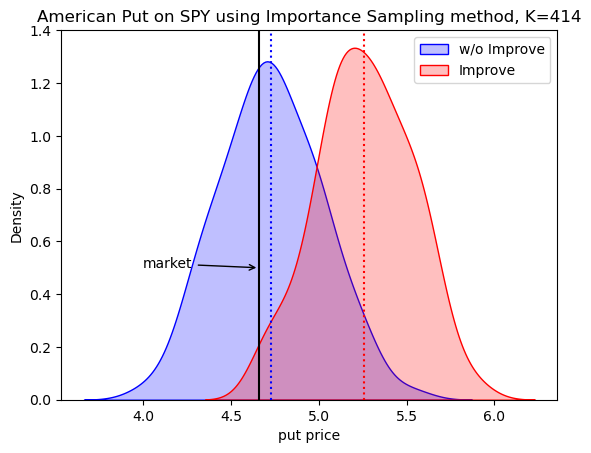

In [16]:
aop = normal_ao_pricing(426.43, 414, 0.0558, 0.21162692, 29, 1000, "put", 4.659999847)
aop.comparison_visual(2, 100)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 20


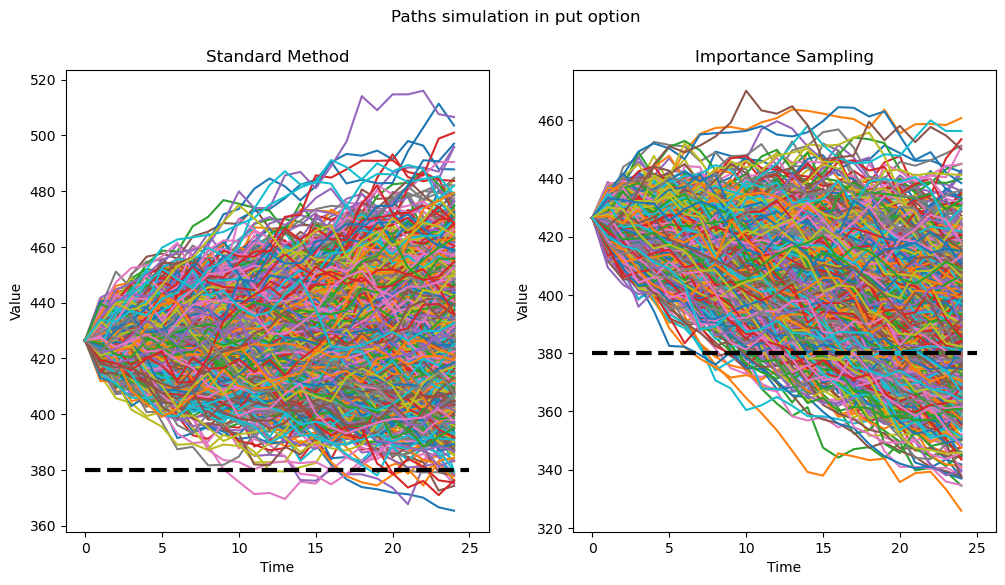

In [20]:
aop = normal_ao_pricing(426.43, 380, 0.0558, 0.21162692, 29, 1000, "put", 4.659999847)
aop.drawing_path_with_strike()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 20


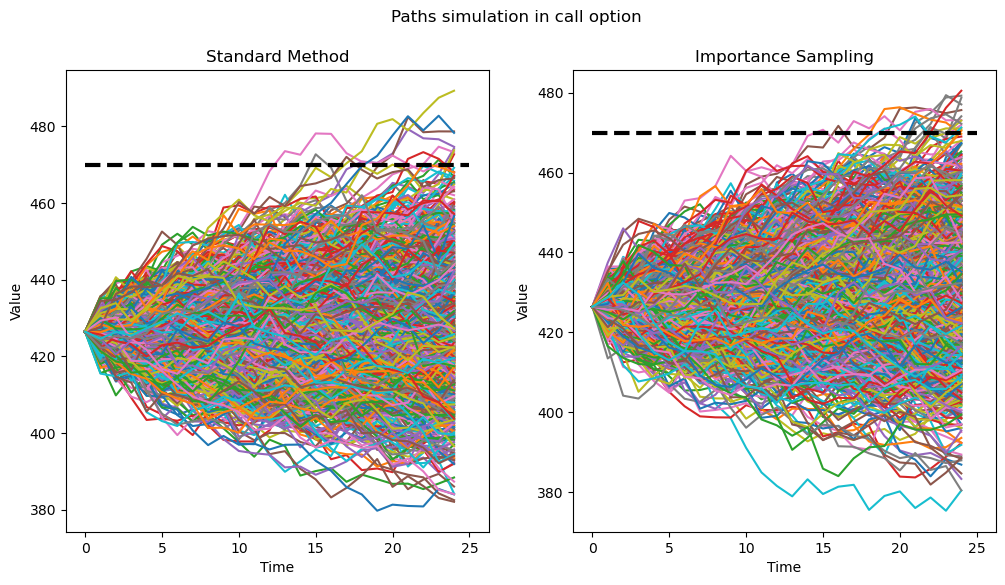

In [25]:
aop = normal_ao_pricing(426.43, 470, 0.0558, 0.1514816601, 29, 1000, "call", 3.640000105)
aop.drawing_path_with_strike()